(ifu-line-fitting-doc)=
# IFS line fitting

In this tutorial, we are going to fit the lines from the [SHOC579](https://dr17.sdss.org/marvin/galaxy/8626-12704/) MANGA observation, using the spatial masks we in the [previous tutorial](../2_guides/6_ifu_spatial_masking.ipynb).

Let’s start by creating the [$\tt{lime.Cube}$ observation](../1_introduction/1_observations.ipynb)

a string value was expected. [astropy.wcs.wcs]
/home/vital/anaconda3/envs/lime2/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4859: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


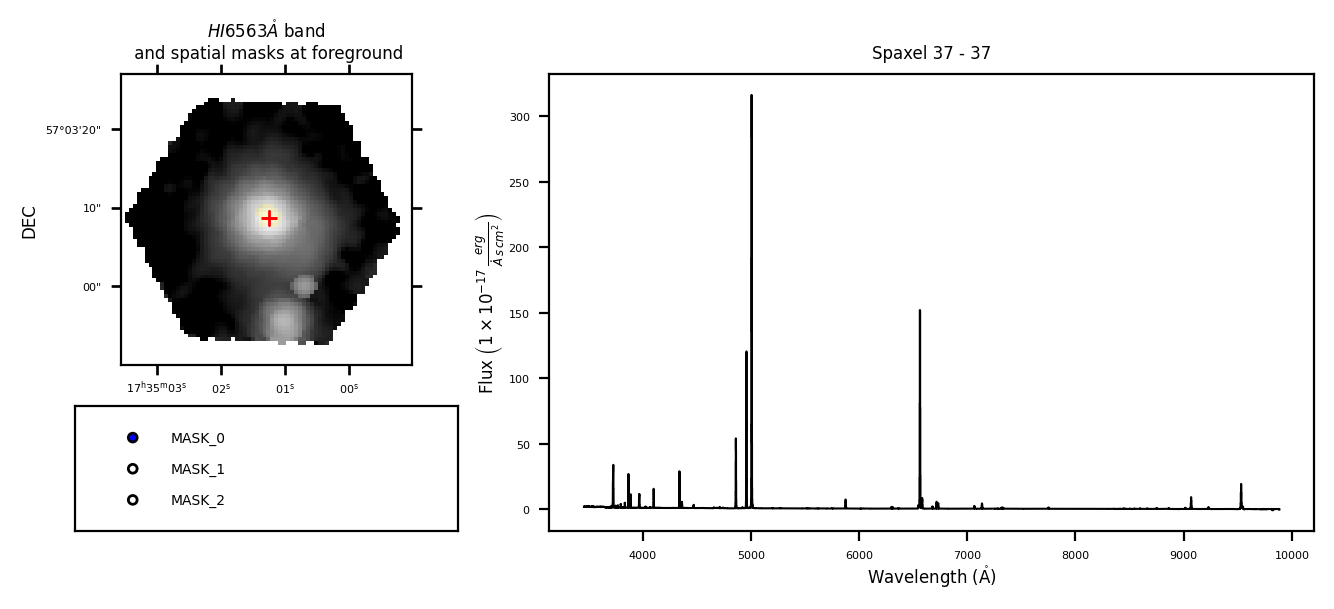

In [1]:
import lime
from pathlib import Path

# State the data location
cfg_file = '../0_resources/ifu_manga.toml'
cube_address = Path('../0_resources/spectra/manga-8626-12704-LOGCUBE.fits.gz')
bands_file_0 = Path('../0_resources/bands/SHOC579_MASK0_bands.txt')
spatial_mask_file = Path('../0_resources/results/SHOC579_mask_SN_line.fits')
output_lines_log_file = Path('../0_resources/SHOC579_log.fits')

# Load the configuration file:
obs_cfg = lime.load_cfg(cfg_file)

# Load the Cube
z_obj = obs_cfg['SHOC579']['redshift']
shoc579 = lime.Cube.from_file(cube_address, instrument='manga', redshift=z_obj)
shoc579.check.cube('H1_6563A', masks_file=spatial_mask_file, rest_frame=True)

## Individual spaxel analysis

You can analyse the spectrum from a single spaxel using the $\tt{lime.Cube.get\_spectrum}$ function:

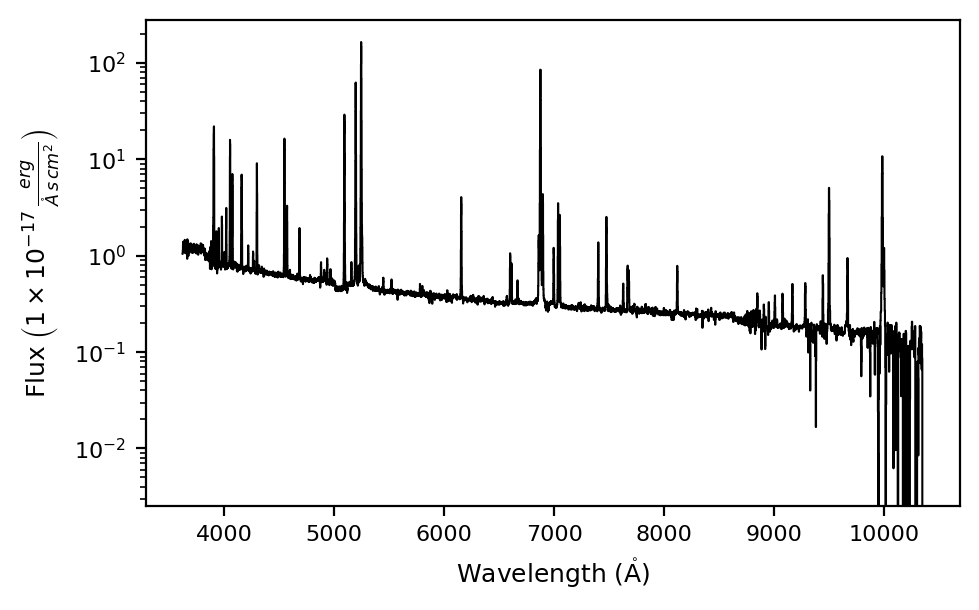

In [2]:
# Extract one spaxel (idx Y, idx X):
spaxel = shoc579.get_spectrum(38, 35)
spaxel.plot.spectrum(log_scale=True)

<div class="alert alert-success">

**Please remember:** The coordinates from the $\tt{lime.Cube.get\_spectrum}$ are those from cube [numpy array](https://numpy.org/devdocs/_images/np_matrix_indexing.png), the first and second indeces correspond to the vertical and horizontal axis respectively. These are the spatial axis on an IFU observation. The third index corresponds to the cube depth axis or the IFU wavelength array. You can use the [$\tt{lime.Cube.check.cube}$](../3_explanations/0_measurements.rst) function to check the spaxel coordinates.

</div>

At this point, we can follow the steps from the [multi-file line fitting](../2_guides/5_multifile-line.ipynb) for a single spaxel:

In [3]:
spaxel.fit.frame(bands_file_0, cfg_file, line_detection=True, obj_cfg_prefix='MASK_0')


Line fitting progress (continuum fitting) (line detection):
[==========] 100% of 39 lines (S3_9531A_b)

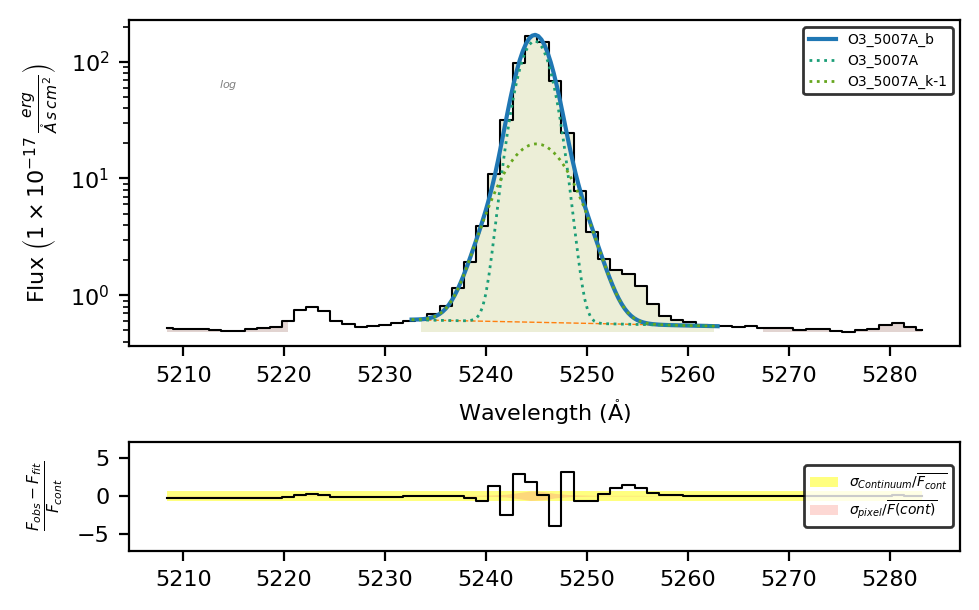

In [4]:
spaxel.plot.bands('O3_5007A')

Or looping though a mask spaxels using the [$\tt{lime.load\_spatial\_mask}$](../3_explanations/0_measurements.rst) function:

In [5]:
masks_dict = lime.load_spatial_mask(spatial_mask_file, return_coords=True)
for i, coords in enumerate(masks_dict['MASK_0']):
    print(f'Spaxel {i + 1}/{len(masks_dict['MASK_0'])}) Coordinates {coords}')
    idx_Y, idx_X = coords
    spaxel_i = shoc579.get_spectrum(idx_Y, idx_Y)
    spaxel_i.fit.frame(bands_file_0, obs_cfg, line_list=['H1_6563A_b'], obj_cfg_prefix='MASK_0', progress_output=None)

Spaxel 1/33) Coordinates [35 35]
Spaxel 2/33) Coordinates [35 36]
Spaxel 3/33) Coordinates [35 38]
Spaxel 4/33) Coordinates [35 39]
Spaxel 5/33) Coordinates [36 35]
Spaxel 6/33) Coordinates [36 36]
Spaxel 7/33) Coordinates [36 37]
Spaxel 8/33) Coordinates [36 38]
Spaxel 9/33) Coordinates [36 39]
Spaxel 10/33) Coordinates [36 40]
Spaxel 11/33) Coordinates [37 35]
Spaxel 12/33) Coordinates [37 36]
Spaxel 13/33) Coordinates [37 37]
Spaxel 14/33) Coordinates [37 38]
Spaxel 15/33) Coordinates [37 39]
Spaxel 16/33) Coordinates [37 40]
Spaxel 17/33) Coordinates [38 34]
Spaxel 18/33) Coordinates [38 35]
Spaxel 19/33) Coordinates [38 36]
Spaxel 20/33) Coordinates [38 37]
Spaxel 21/33) Coordinates [38 38]
Spaxel 22/33) Coordinates [38 39]
Spaxel 23/33) Coordinates [38 40]
Spaxel 24/33) Coordinates [39 34]
Spaxel 25/33) Coordinates [39 35]
Spaxel 26/33) Coordinates [39 36]
Spaxel 27/33) Coordinates [39 37]
Spaxel 28/33) Coordinates [39 38]
Spaxel 29/33) Coordinates [39 39]
Spaxel 30/33) Coordinat

## Spatial masks analysis

To treat serveral spaxels in an efficient workflow, you can use the [$\tt{lime.Cube.fit.spatial\_mask}$](../3_explanations/0_measurements.rst). This function allows you to fit some or all the masks in the input ``spatial_mask_file``. Moreover, it will save the results in a multi-page *.fits* file.

In [7]:
# Fit the lines in all the masks spaxels
shoc579.fit.spatial_mask(spatial_mask_file, fit_cfg=cfg_file, line_detection=True, fname=output_lines_log_file)


Spatial mask 1/3) MASK_0 (33 spaxels)
[==========] 100% of mask (spaxel coordinate. 40-38)
1633 lines measured in 0.36 minutes.

Spatial mask 2/3) MASK_1 (97 spaxels)
[==========] 100% of mask (spaxel coordinate. 43-39)
3218 lines measured in 0.75 minutes.

Spatial mask 3/3) MASK_2 (97 spaxels)
[==========] 100% of mask (spaxel coordinate. 54-26)

LiMe WARNING: Gaussian fit uncertainty estimation failed for Ne3_3869A



1341 lines measured in 0.40 minutes.

Joining spatial log files (MASK_0,MASK_1,MASK_2) -> ../0_resources/SHOC579_log.fits
[==========] 100% of log files combined 

<div class="alert alert-info">

**Please remember:** The ``.fit.spatial_mask`` function cannot add or update measurements on an existing *.fits* file. It will always overwrite an existing file on the provided ``output_log`` path.

</div>

The [$\tt{lime.Cube.fit.spatial\_mask}$](../3_explanations/0_measurements.rst) is performing multiple tasks behind the scenes:
* Getting the coordinates from the spaxels from the [spatial mask file0](../2_guides/6_ifu_spatial_masking.ipynb).
* Reading the fitting configuration from the sections. 
* Loading a distintive [lines frame](../2_guides/1_prepare_line_bands.ipynb) for each spatial mask where the address is specied in the ``fit_cfg`` argument. The addunder the   spatial masks  the coordinates from the spaxels from the [spatial mask file0](../2_guides/6_ifu_spatial_masking.ipynb). The address of the lines frame files must be specified under the **mask** line fitting configuration using the **bands** key.
* Run the [continuum fitting](../2_guides/3_continuum_fitting.ipynb) and [peak_troughs thresholding](../2_guides/4_line_detection.ipynb) at each spaxel and then measure the detected lines.
* Save the spatial mask measurements to an individual **.fits** file and then joining them (unless ``join_output_files=False``)

Finally, the [$\tt{lime.Cube.fit.spatial\_mask}$](../3_explanations/0_measurements.rst) has up-to three [fitting configuration levels](../2_guides/5_multifile-line.ipynb) (**default**, **mask** and **object** ) from the input ``fit_cfg``:
* At the lowest level, the *[default_line_fitting]* section provides a fitting configuration all spaxels, independtly of the mask. The name of this section can be modified with the ``default_conf_prefix="default"`` 
* The *[MASK_0_line_fitting]*, *[MASK_1_line_fitting]* and *[MASK_2_line_fitting]* sections provide the fitting configuration for each mask. These entries **update** the information from the *[default_line_fitting]*. This means that:
    * In all the masked spaxels *H1_3889A_m=H1_3889A+He1_3889A* and *Ar4_4711A_m = Ar4_4711A-He1_4713A*.
    * In *[MASK_0_line_fitting]* the line ``O2_3726A_b`` has four components while in *[MASK_1_line_fitting]* it only has two
    * Since *[MASK_2_line_fitting]* does not have any items, the fitting configuration is the same as in *[default_line_fitting]*.
* At the highest level the *[38-35_line_fitting]* section updates the fitting properties of the spaxel on red. Consequently, just in that spaxel *O3_5007A_b = O3_5007A+O3_5007A_k-1+He1_5016A*. Again this entry **updates** the information from the *[MASK_0_line_fitting]* and the *[default_line_fitting]* sections.

We can confirm this configuration by checking this spaxel, the only one with the fitting of the $HeI5016Å$ line: 

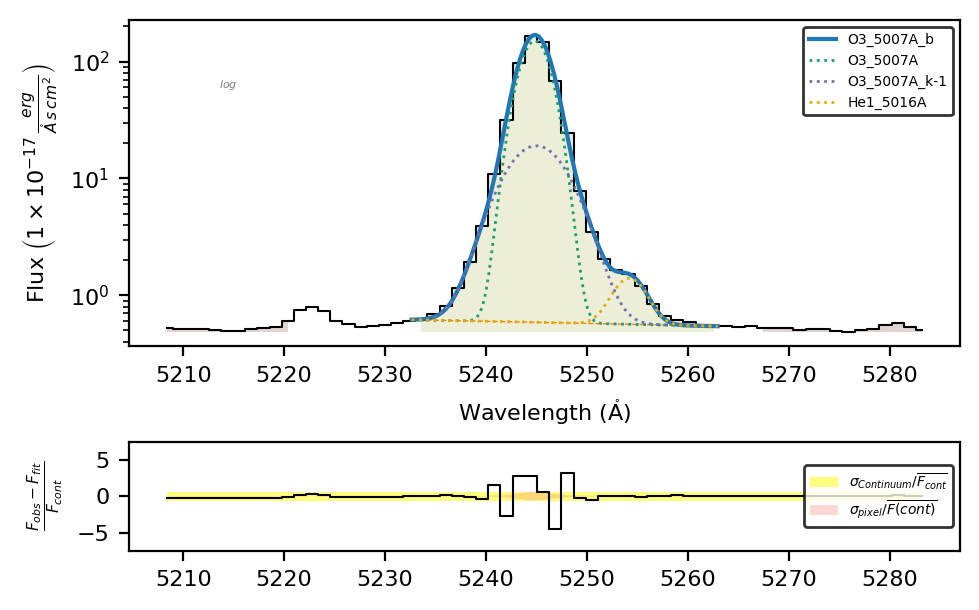

In [8]:
# Check the individual spaxel fitting configuration
spaxel = shoc579.get_spectrum(38, 35)
spaxel.load_frame(output_lines_log_file, page='38-35_LINELOG')
spaxel.plot.bands('He1_5016A')

The *.fits* extensions are named **idxY-idxX_LINELOG** where *(idxY, idxX)* are the vertical and horizontal numpy array coordinates. You can change the default extension suffix with the ``log_ext_suffix='_LINELOG'`` argument.

## Take aways
* The $\tt{lime.Cube.get\_spectrum}$ can be used to extract the $\tt{lime.Spectrum}$ from an individual spaxel using the cube numpy array coordinates.
* The [$\tt{lime.load\_spatial\_mask}$](../3_explanations/0_measurements.rst) function can extract the cube numpy arrays from a mask file.
* The [$\tt{lime.Cube.fit.spatial\_mask}$](../3_explanations/0_measurements.rst) function can fit the lines from the spaxels in a ``mask_file`` and save the results in a multi-page *fits* file.
* This function provides all the tools from the [$\tt{lime.Spectrum.fit.frame}$](../3_explanations/0_measurements.rst) with up-to three configuration layers to adjust the measurements.
* You can read the function documentation in the [API](https://lime-stable.readthedocs.io/en/latest/reference/API.html).
